In [ ]:
load_ext rpy2.ipython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cp drive/MyDrive/src/library.tar.gz .
!du -sh library.tar.gz

727M	library.tar.gz


In [ ]:
!tar xf library.tar.gz

tar: Removing leading `/' from member names


In [ ]:
%ls usr/local/lib/R/site-library/

abind/           gdata/             listenv/         RSpectra/
AnnotationDbi/   GenomeInfoDb/      lme4/            RSQLite/
aricode/         GenomeInfoDbData/  lmtest/          Rtsne/
BH/              GenomicRanges/     MatrixGenerics/  S4Vectors/
Biobase/         ggrepel/           matrixStats/     sass/
BiocGenerics/    ggridges/          mice/            scattermore/
BiocManager/     globals/           miniUI/          sctransform/
BiocVersion/     GO.db/             minqa/           Seurat/
Biostrings/      goftest/           nloptr/          SeuratObject/
bitops/          gplots/            parallelly/      shiny/
bslib/           gridExtra/         patchwork/       SingleCellExperiment/
caTools/         gtools/            pbapply/         sitmo/
checkmate/       hdf5r/             pbdZMQ/          sourcetools/
cNORM/           here/              plogr/           spatstat.core/
corpcor/         Hmisc/             plotly/          spatstat.data/
cowplot/         htmlTable/        

In [ ]:
%%R
.libPaths('usr/local/lib/R/site-library/')

In [ ]:
%%R
.libPaths()

[1] "/content/usr/local/lib/R/site-library"
[2] "/usr/local/lib/R/site-library"        
[3] "/usr/lib/R/site-library"              
[4] "/usr/lib/R/library"                   


In [ ]:
%%R
library(SuperCell)
library(Seurat)
library(aricode)
library(SingleCellExperiment)
library(WGCNA)

In [ ]:
%%R
install.packages('devtools')
devtools::install_github('JiekaiLab/dior')

R[write to console]: 

R[write to console]: 
R[write to console]: The downloaded source packages are in
	‘/tmp/RtmpAhoGj4/downloaded_packages’
R[write to console]: 
R[write to console]: 

R[write to console]: Skipping install of 'dior' from a github remote, the SHA1 (2b1ea47b) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
%%R
library(dior)

In [ ]:
%%R
seuratObj = read_h5(file = '/content/drive/MyDrive/Datasets/adata_cortex.h5', assay.name = "RNA")

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')



In [ ]:
%%R
dim(seuratObj@assays[["RNA"]]@counts)

[1] 26662 18641


In [ ]:
%%R
GE = seuratObj@assays[["RNA"]]@counts   #assigning expression data
cell.meta = seuratObj@meta.data[["cell_type"]]  #assigning cell names
gamma <- 20

In [ ]:
%%R
SCimplify2 <- function(X,
                       genes.use = NULL,
                       genes.exclude = NULL,
                       n.var.genes = min(1000, nrow(X)),
                       gamma = 10,
                       k.knn = 5,
                       do.scale = TRUE,
                       n.pc = 10,
                       fast.pca = TRUE,
                       do.approx = FALSE,
                       approx.N = 20000,
                       directed = FALSE,
                       use.nn2 = TRUE,
                       seed = 12345,
                       p = 2,
                       dist_method = "euclidean",
                       igraph.clustering = c("walktrap", "louvain"),
                       return.singlecell.NW = TRUE,
                       return.hierarchical.structure = TRUE,
                       block.size = 10000){
  
  N.c <- ncol(X)
  
  if(is.null(rownames(X))){
    if(!(is.null(genes.use) | is.null(genes.exclude))){
      stop("rownames(X) is Null \nGene expression matrix X is expected to have genes as rownames")
    } else {
      warning("colnames(X) is Null, \nGene expression matrix X is expected to have genes as rownames! \ngenes will be created automatically in a form 'gene_i' ")
      rownames(X) <- paste("gene", 1:nrow(X), sep = "_")
    }
  }
  
  if(is.null(colnames(X))){
    warning("colnames(X) is Null, \nGene expression matrix X is expected to have cellIDs as colnames! \nCellIDs will be created automatically in a form 'cell_i' ")
    colnames(X) <- paste("cell", 1:N.c, sep = "_")
  }
  
  keep.genes    <- setdiff(rownames(X), genes.exclude)
  X             <- X[keep.genes,]
  
  
  if(is.null(genes.use)){
    n.var.genes <- min(n.var.genes, nrow(X))
    if(N.c > 50000){
      set.seed(seed)
      idx         <- sample(N.c, 50000)
      gene.var    <- apply(X[,idx], 1, var)
    } else {
      gene.var    <- apply(X, 1, var)
    }
    
    genes.use   <- names(sort(gene.var, decreasing = TRUE))[1:n.var.genes]
  }
  
  if(length(intersect(genes.use, genes.exclude)) > 0){
    stop("Sets of genes.use and genes.exclude have non-empty intersection")
  }
  
  genes.use <- genes.use[genes.use %in% rownames(X)]
  X <- X[genes.use,]
  
  if(do.approx & approx.N >= N.c){
    do.approx <- FALSE
    warning("N.approx is larger or equal to the number of single cells, thus, an exact simplification will be performed")
  }
  
  if(do.approx & (approx.N < round(N.c/gamma))){
    approx.N <- round(N.c/gamma)
    warning(paste("N.approx is set to N.SC", approx.N))
  }
  
  if(do.approx & ((N.c/gamma) > (approx.N/3))){
    warning("N.approx is not much larger than desired number of super-cells, so an approximate simplification may take londer than an exact one!")
  }
  
  if(do.approx){
    set.seed(seed)
    approx.N            <- min(approx.N, N.c)
    presample           <- sample(1:N.c, size = approx.N, replace = FALSE)
    presampled.cell.ids <- colnames(X)[sort(presample)]
    rest.cell.ids       <- setdiff(colnames(X), presampled.cell.ids)
  } else {
    presampled.cell.ids <- colnames(X)
    rest.cell.ids       <- c()
  }
  
  X.for.pca            <- Matrix::t(X[genes.use, presampled.cell.ids])
  if(do.scale){ X.for.pca            <- scale(X.for.pca) }
  X.for.pca[is.na(X.for.pca)] <- 0
  
  if(is.null(n.pc[1]) | min(n.pc) < 1){stop("Please, provide a range or a number of components to use: n.pc")}
  if(length(n.pc)==1) n.pc <- 1:n.pc
  
  if(fast.pca & (N.c < 1000)){
    warning("Normal pca is computed because number of cell is low for irlba::irlba()")
    fast.pca <- FALSE
  }
  
  if(!fast.pca){
    PCA.presampled          <- prcomp(X.for.pca, rank. = max(n.pc), scale. = F, center = F)
  } else {
    PCA.presampled          <- irlba::irlba(X.for.pca, nv = max(n.pc, 25))
    PCA.presampled$x        <- PCA.presampled$u %*% diag(PCA.presampled$d)
    PCA.presampled$rotation <- PCA.presampled$v
  }
  
  sc.nw <- build_knn_graph2(X = PCA.presampled$x[,n.pc], k = k.knn, from = "coordinates", use.nn2 = use.nn2, dist_method = dist_method, directed = directed, p = p)
  
  #simplify
  
  k   <- round(N.c/gamma)
  
  if(igraph.clustering[1] == "walktrap"){
    g.s              <- igraph::cluster_walktrap(sc.nw$graph.knn)
    g.s$membership   <- igraph::cut_at(g.s, k)
    
  } else if(igraph.clustering[1] == "louvain") {
    warning(paste("igraph.clustering =", igraph.clustering, ", gamma is ignored"))
    g.s    <- igraph::cluster_louvain(sc.nw$graph.knn)
    
  } else {
    stop(paste("Unknown clustering method (", igraph.clustering, "), please use louvain or walkrtap"))
  }
  
  membership.presampled        <- g.s$membership
  names(membership.presampled) <- presampled.cell.ids
  
  SC.NW                        <- igraph::contract(sc.nw$graph.knn, membership.presampled)
  SC.NW                        <- igraph::simplify(SC.NW, remove.loops = T, edge.attr.comb="sum")
  
  if(do.approx){
    
    PCA.averaged.SC      <- as.matrix(Matrix::t(supercell_GE(t(PCA.presampled$x[,n.pc]), groups = membership.presampled)))
    X.for.roration       <- Matrix::t(X[genes.use, rest.cell.ids])
    
    
    
    if(do.scale){ X.for.roration <- scale(X.for.roration) }
    X.for.roration[is.na(X.for.roration)] <- 0
    
    
    membership.omitted   <- c()
    if(is.null(block.size) | is.na(block.size)) block.size <- 10000
    
    N.blocks <- length(rest.cell.ids)%/%block.size
    if(length(rest.cell.ids)%%block.size > 0) N.blocks <- N.blocks+1
    
    
    if(N.blocks>0){
      for(i in 1:N.blocks){ # compute knn by blocks
        idx.begin <- (i-1)*block.size + 1
        idx.end   <- min(i*block.size,  length(rest.cell.ids))
        
        cur.rest.cell.ids    <- rest.cell.ids[idx.begin:idx.end]
        
        PCA.ommited          <- X.for.roration[cur.rest.cell.ids,] %*% PCA.presampled$rotation[, n.pc] ###
        
        D.omitted.subsampled <- proxy::dist(PCA.ommited, PCA.averaged.SC) ###
        
        membership.omitted.cur        <- apply(D.omitted.subsampled, 1, which.min) ###
        names(membership.omitted.cur) <- cur.rest.cell.ids ###
        
        membership.omitted   <- c(membership.omitted, membership.omitted.cur)
      }
    }
    
    membership.all       <- c(membership.presampled, membership.omitted)
    membership.all       <- membership.all[colnames(X)]
  } else {
    membership.all       <- membership.presampled[colnames(X)]
  }
  
  membership       <- membership.all
  
  supercell_size   <- as.vector(table(membership))
  
  igraph::E(SC.NW)$width         <- sqrt(igraph::E(SC.NW)$weight/10)
  igraph::V(SC.NW)$size          <- supercell_size
  igraph::V(SC.NW)$sizesqrt      <- sqrt(igraph::V(SC.NW)$size)
  
  res <- list(graph.supercells = SC.NW,
              gamma = gamma,
              N.SC = length(membership),
              membership = membership,
              supercell_size = supercell_size,
              genes.use = genes.use,
              simplification.algo = igraph.clustering[1],
              do.approx = do.approx,
              n.pc = n.pc,
              k.knn = k.knn)
  
  if(return.singlecell.NW){res$graph.singlecell <- sc.nw$graph.knn}
  
  if(igraph.clustering[1] == "walktrap" & return.hierarchical.structure)  res$h_membership <- g.s
  
  return(res)
}

In [ ]:
%%R
#' Build kNN graph
#'
#' Build kNN graph either from distance (from == "dist") or from coordinates (from == "coordinates")
#'
#' @param X either distance or matrix of coordinates (rows are samples and cols are coordinates)
#' @param k kNN parameter
#' @param from from which data type to build kNN network: "dist" if X is a distance (dissimilarity) or "coordinates" if X is a matrix with coordinates as cols and cells as rows
#' @param use.nn2 whether use RANN::nn2 method to buid kNN network faster (avaivable only for "coordinates" option)
#' @param return_neighbors_order whether return order of neighbors (not available for nn2 option)
#' @param dist_method method to compute dist (if X is a matrix of coordinates) available: c("cor", "euclidean", "maximum", "manhattan", "canberra", "binary", "minkowski")
#' @param cor_method if distance is computed as correlation (dist_method == "cor), which type of correlation to use (available: "pearson", "kendall", "spearman")
#' @param p p param in \code{"dist"} function
#' @param directed whether to build a directed graph
#'
#' @return a list with components
#' \itemize{
#'   \item graph.knn - igraph object
#'   \item order - Nxk matrix with indecies of k nearest neighbors ordered by relevance (from 1st to k-th)
#' }
#'
#' @export
#'

build_knn_graph2 <- function(
  X,
  k = 5,
  from = c("dist", "coordinates"),
  use.nn2 = TRUE,
  return_neighbors_order = F,
  dist_method = "euclidean",
  cor_method = "pearson",
  p = 2,
  directed = FALSE
  )
{
  av.methods <- c("dist", "coordinates")
  method <-  pmatch(from[1], av.methods)
  if(is.na(method)){
    stop(paste("Unlnown method", from, "Available methods are", paste(av.methods, collapse = ", ")))
  }


  if (method == 2){ # from coordinates
    if(use.nn2){
      if(dist_method != "euclidean"){
        stop(paste0("Fast nn2 function from RANN package is used, so",
                    dist_method, "distnce is not acceptable.
                  To use nn2 method, please, choose eucleadian distance.
                  If you want to use", dist_method, "distance, please set parameter use.nn2 to FALSE"))}
      mode <- ifelse(directed, 'out', 'all')
      return(build_knn_graph_nn2(X = X, k = k, mode = mode))
    } else {
      av.dist      <- c("cor", "euclidean", "maximum", "manhattan", "canberra", "binary", "minkowski", "cosine")
      dist_method_ <-  pmatch(dist_method, av.dist)
      if(is.na(dist_method_)){
        stop(paste("Unknown distance method:", dist_method, "Available dist methods are", paste(av.dist, collapse = ", ") ))
      }
      if(dist_method_ == 1){
        #print("cor")
        #print(cor_method)
        av.cor_methods <- c("pearson", "kendall", "spearman")
        cor_method_    <- pmatch(cor_method, av.cor_methods)
        if(is.na(cor_method_)){
          stop(paste("Unknown cor method:", cor_method, "Available cor methods are", paste(av.cor_methods)))
        }
        X <- as.dist(as.matrix(1 - cor(t(X), method = cor_method)))
      } else if(dist_method_ == 8){
        #print("cosine")
        av.cor_methods <- c("pearson", "kendall", "spearman")
        #print(av.cor_methods)
        cor_method_    <- pmatch(cor_method, av.cor_methods)
        #print(cor_method_)
        if(is.na(cor_method_)){
          stop(paste("Unknown cor method:", cor_method, "Available cor methods are", paste(av.cor_methods)))
        }
        v = WGCNA::cor(t(X), method = cor_method, cosine = TRUE)
        X <- as.dist(as.matrix(1 - v))
        #cor(t(X), method = cor_method,cosine = True)
        print("X")
      } else {
        X <- dist(X, method = dist_method, p = p)
      }
    }
  } else {
    if(use.nn2 == TRUE){
      stop("Method nn2 cannot be applied to distance, to use fast nn2 method, please provide coordinates rather than distance
             and set parameter from to coordinates")
    }
    return(knn_graph_from_dist(D = X, k = k, return_neighbors_order = return_neighbors_order))
  }


  ### now X is distance in any case
  return(knn_graph_from_dist(D = X, k = k, return_neighbors_order = return_neighbors_order))

}


#' Build kNN graph using RANN::nn2
#' (used in \code{"build_knn_graph"})
#'
#' @param X matrix of coordinates (rows are samples and cols are coordinates)
#' @param k kNN parameter
#' @param return_neighbors_order whether return order of neighbors
#' @param mode mode of \link[igraph]{graph_from_adj_list} ('all' -- undirected graph, 'out' -- directed graph)
#'

#' @return a list with components
#' \itemize{
#'   \item graph.knn - igraph object
#' }
#'

build_knn_graph_nn2 <- function(X, k = min(5, ncol(X)), mode = 'all'){
  nn2.res <- RANN::nn2(data = X, k = k)
  nn2.res <- nn2.res$nn.idx

  adj.knn       <- split(nn2.res, rep(1:nrow(nn2.res), times = ncol(nn2.res))) # get adj list

  graph.knn     <- igraph::graph_from_adj_list(adj.knn,  duplicate = F, mode = mode)

  graph.knn     <- igraph::simplify(graph.knn, remove.multiple = T)
  igraph::E(graph.knn)$weight <- 1

  return(res <- list(graph.knn = graph.knn))

}


#' Build kNN graph from distance
#' (used in \code{"build_knn_graph"})
#'
#' @param X dist matrix or dist object (preferentially)
#' @param k kNN parameter
#' @param mode mode of \link[igraph]{graph_from_adj_list} ('all' -- undirected graph, 'out' -- directed graph)
#'
#' @return a list with components
#' \itemize{
#'   \item graph.knn - igraph object
#'   \item order - Nxk matrix with indecies of k nearest neighbors ordered by relevance (from 1st to k-th)
#' }
#'

knn_graph_from_dist <- function(D, k = 5, return_neighbors_order = T, mode = 'all'){

  ##print("Start knn_graph_from_dist")
  if(!is.matrix(D) & class(D) != "dist"){
    stop("D (X) mast be a matrix or dist!")
  }

  if(class(D) != "dist"){
    D <- as.dist(D)
  }



  N        <- (1 + sqrt(1+8*length(D)))/2 # number of cells

  if (k >= N)
    stop("Not enought neighbors in data set!")
  if (k < 1)
    stop("Invalid number of nearest neighbors, k must be >= 1!")

  row <- function(i, N){
    return(c(if(i>1) D[(i-1)+c(0:(i-2))*(N - 1 - c(1:(i-1))/2)],
             NA,
             if(i < N) D[((i-1)*(N-1) - ((i-1)*(i-2)/2) + 1) : (((i-1)*(N-1) - ((i-1)*(i-2)/2) + 1) + N-i-1)]))
  }

  neighbors <- t(sapply(1:N, function(i) {order(row(i,N))[1:k]}))

  adj.knn <- split(neighbors, rep(1:nrow(neighbors), times = ncol(neighbors)))


  graph.knn     <- igraph::graph_from_adj_list(adj.knn,  duplicate = F, mode = mode)
  graph.knn     <- igraph::simplify(graph.knn, remove.multiple = T)
  igraph::E(graph.knn)$weight <- 1

  if(return_neighbors_order){
    res <- list(graph.knn = graph.knn,
                order = neighbors)
  } else {res <- list(graph.knn = graph.knn)}

  return(res)
}

In [ ]:
%%R
gamma = 35

In [ ]:
%%R
lst = data.frame(
  dis = c("cosine","euclidean", "cor", "manhattan", "canberra", "maximum", "minkowski_0.5", "minkowski_0.1"),
  ari = c(0,0,0,0,0,0,0,0)
)  

In [ ]:
%%R
for (i in 1:6){  
  SC <- SCimplify2(GE,k.knn = 5,gamma = gamma,n.var.genes = 1000,directed = FALSE, dist_method = lst$dis[i],use.nn2 = FALSE)
  SC.GE <- supercell_GE(GE, SC$membership)
  SC$cell_line <- supercell_assign(clusters = cell.meta, # single-cell assignment to cell lines (clusters)
                                   supercell_membership = SC$membership, # single-cell assignment to super-cells
                                   method = "jaccard")
  SC.PCA         <- supercell_prcomp(Matrix::t(SC.GE), # super-cell gene expression matrix
                                     genes.use = SC$genes.use, # genes used for the coarse-graining, but any set can be provided
                                     supercell_size = SC$supercell_size, # sample-weighted pca
                                     k = 20)
  D              <- dist(SC.PCA$x)
  m.seurat <- supercell_2_Seurat(SC.GE = SC.GE, SC = SC, fields = c("cell_line"))
  m.seurat <- FindClusters(m.seurat, graph.name = "RNA_nn") # now RNA_nn is super-cell network
  m_clust = SC[["membership"]]
  for (x in 1:length(m_clust)){
    m_clust[x] = m.seurat@meta.data[["seurat_clusters"]][m_clust[x]]
  }
  cell.meta = unlist(cell.meta)
  lst$ari[i] = ARI(m_clust,cell.meta)
}


[1] "X"


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 316

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.7082
Number of communities: 6
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 333

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6833
Number of communities: 5
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 306

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6981
Number of communities: 7
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 348

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6849
Number of communities: 5
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 518

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6266
Number of communities: 4
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 350

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6585
Number of communities: 5
Elapsed time: 0 seconds


In [ ]:
%%R
for (i in 7:8){
  p = 2 
  if (i == 7){
      p = 0.5
  } else{
      p = 0.1
  } 
  SC <- SCimplify2(GE,k.knn = 5,gamma = gamma,n.var.genes = 1000,directed = FALSE, dist_method = "minkowski",use.nn2 = FALSE, p = p)
  SC.GE <- supercell_GE(GE, SC$membership)
  SC$cell_line <- supercell_assign(clusters = cell.meta, # single-cell assignment to cell lines (clusters)
                                   supercell_membership = SC$membership, # single-cell assignment to super-cells
                                   method = "jaccard")
  SC.PCA         <- supercell_prcomp(Matrix::t(SC.GE), # super-cell gene expression matrix
                                     genes.use = SC$genes.use, # genes used for the coarse-graining, but any set can be provided
                                     supercell_size = SC$supercell_size, # sample-weighted pca
                                     k = 20)
  D              <- dist(SC.PCA$x)
  m.seurat <- supercell_2_Seurat(SC.GE = SC.GE, SC = SC, fields = c("cell_line"))
  m.seurat <- FindClusters(m.seurat, graph.name = "RNA_nn") # now RNA_nn is super-cell network
  m_clust = SC[["membership"]]
  for (x in 1:length(m_clust)){
    m_clust[x] = m.seurat@meta.data[["seurat_clusters"]][m_clust[x]]
  }
  lst$ari[i] = ARI(m_clust,cell.meta)
}

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 413

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.6719
Number of communities: 5
Elapsed time: 0 seconds


R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

[1] "Done: NormalizeData"
[1] "Doing: data to normalized data"
[1] "Doing: weighted scaling"
[1] "Done: weighted scaling"


R[write to console]: Warning in irlba(A = t(x = object), nv = npcs, ...) :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 86
Number of edges: 695

Running Louvain algorithm...


R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

Maximum modularity in 10 random starts: 0.5829
Number of communities: 5
Elapsed time: 0 seconds


In [ ]:
%%R
print(lst)

            dis       ari
1        cosine 0.8716422
2     euclidean 0.8113960
3           cor 0.7422743
4     manhattan 0.8469386
5      canberra 0.6585277
6       maximum 0.6533754
7 minkowski_0.5 0.8256658
8 minkowski_0.1 0.5814810


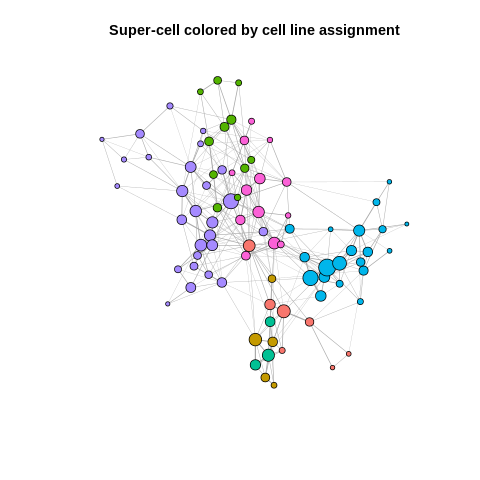

In [ ]:
%%R
SC <- SCimplify2(GE,k.knn = 5,gamma = gamma,n.var.genes = 1000,directed = FALSE, dist_method = "euclidean",use.nn2 = FALSE, p = 0.5)
SC.GE <- supercell_GE(GE, SC$membership)
SC$cell_line <- supercell_assign(clusters = cell.meta, # single-cell assignment to cell lines (clusters)
                                   supercell_membership = SC$membership, # single-cell assignment to super-cells
                                   method = "jaccard")
seed <- 1 # seed for super-cell network plotting
supercell_plot(SC$graph.supercells, 
               group = SC$cell_line, 
               seed = seed, 
               main  = "Super-cell colored by cell line assignment")  

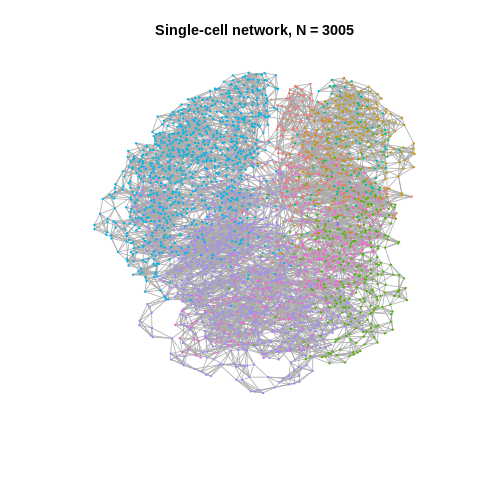

In [ ]:
%%R
supercell_plot(SC$graph.singlecell, # network
               group = cell.meta, # colored by cell line assignment
               do.frames = F, # not drawing frames around each node 
               main = paste("Single-cell network, N =", dim(GE)[2]), 
               lay.method = "components") # method to compute the network 2D embedding 